Kevin Frans' [solution](https://github.com/kvfrans/Easy21-RL) to [Easy21](https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf).

In [1]:
# environment.py

import random
import numpy as np

class State:
    dealercard = random.randint(1,10)
    playersum = random.randint(1,10)

# adds some drawn card value
def drawcard(current):
    if random.randint(1,3) < 3:
        current += random.randint(1,10)
    else:
        current -= random.randint(1,10)
    return current

# action {0: stick, 1: hit}
def step(state, action):
    if action == 1:
        state.playersum = drawcard(state.playersum)
        if state.playersum < 1 or state.playersum > 21:
            return "terminal", -1.0
        else:
            return state, 0
    elif action == 0:
        while(state.dealercard < 17):
            state.dealercard = drawcard(state.dealercard)
            if state.dealercard < 1 or state.dealercard > 21:
                return "terminal", 1.0
        if state.dealercard > state.playersum:
            return "terminal", -1.0
        elif state.dealercard < state.playersum:
            return "terminal", 1.0
        else:
            return "terminal", 0.0

In [2]:
# montecarlo.py

def montecarlo(value,counter):
    state = State()
    state.playersum = random.randint(1,10)
    state.dealercard = random.randint(1,10)
    totalreward = 0
    visits = []
    while state != "terminal":
        action = None
        e = 100.0 / (100.0 + np.sum(counter[:,state.dealercard, state.playersum],axis=0))
        if (random.random() < e):
            action = random.randint(0,1)
        else:
            action = np.argmax(value[:, state.dealercard, state.playersum])
        counter[action, state.dealercard, state.playersum] += 1
        visits.append((action, state.dealercard, state.playersum))
        state, reward = step(state, action)
        totalreward += reward
    # since the only reward is at the end, doesn't matter when we visited the state
    # print(f'{visits} => {reward}')
    for action, dealercard, playersum in visits:
        a = 1 / counter[action,dealercard,playersum]
        g = totalreward
        # print "section"
        # print a*(g - value[action,dealercard,playersum])
        value[action,dealercard,playersum] = value[action,dealercard,playersum] + a*(g - value[action,dealercard,playersum])
        # print value[action,dealercard,playersum]
    return value, counter

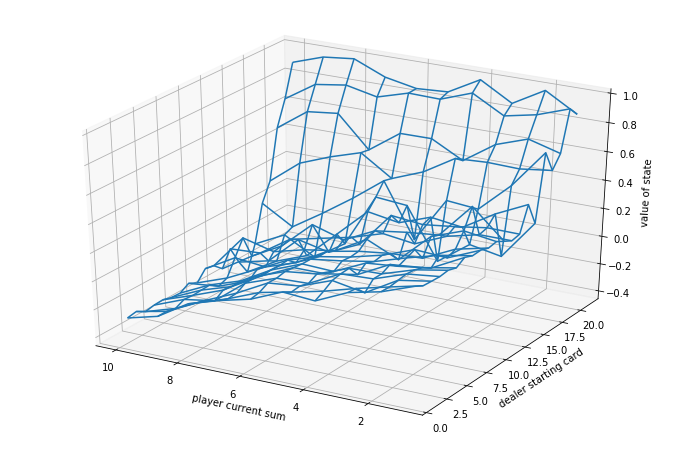

In [3]:
# plot for MC control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# the same random seed so that I am able to compare Kevin's results with mine.
random.seed(20200403)

# value[action][dealercard][playersum] is the value function, table lookup should work with so little states
value = np.zeros((2,11,22))
counter = np.zeros((2,11,22))

# run monte-carlo
for i in range(200000):
     value, counter = montecarlo(value,counter)

# plot monte-carlo value func
fig = plt.figure(figsize=(12, 8))
ha = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(range(1, 11), range(1, 22))
Z = np.array([np.max(value[:, d, p]) for (d, p) in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

ha.plot_wireframe(X, Y, Z)
ha.invert_xaxis()
ha.set_ylabel("dealer starting card")
ha.set_xlabel("player current sum")
ha.set_zlabel("value of state")

plt.show()

In [4]:
# sarsa.py (Forward-view SARSA(lambda))

import math


# scaling = lambda
def sarsa(value,counter,scaling):
    state = State()
    state.dealercard = random.randint(1,10)
    state.playersum = random.randint(1,10)
    transitions = []
    while state != "terminal":
        action = None
        e = 100.0 / (100.0 + np.sum(counter[:,state.dealercard, state.playersum],axis=0))
        if (random.random() < e):
            action = random.randint(0,1)
        else:
            action = np.argmax(value[:, state.dealercard, state.playersum])
        counter[action, state.dealercard, state.playersum] += 1
        old_dealercard = state.dealercard
        old_playersum = state.playersum
        state, reward = step(state, action)
        # i took action A at state S, and got a reward of R.
        # print "i took action %d at state (%d,%d) and got reward %d" % (action, old_dealercard, old_playersum, reward)
        if state != "terminal":
            transitions.append((action, old_dealercard, old_playersum, reward, state.dealercard, state.playersum))
        else:
            transitions.append((action, old_dealercard, old_playersum, reward, -1, -1))

    # for every state that we visited
    for index, item in enumerate(transitions):
        action, dealercard, playersum, reward, _, _ = item
        rewardsum = 0
        g_total = 0
        stepstillend = len(transitions) - index
        # print "updating on state %d, %d" % (dealercard, playersum)
        # for all the states that we saw afterwards
        for lookahead in range(stepstillend):
            # print "looking ahead %d steps" % (lookahead+1)
            nextstatereward = None
            # the state we're observing
            lookaheadstate = transitions[lookahead + index]

            if lookaheadstate[4] == -1:
                # no value for being in terminal state
                nextstatevalue = 0
            else:
                # value of taking optimal action from next state
                nextstatevalue = np.argmax(value[:, lookaheadstate[4], lookaheadstate[5]])

            # add reward that got from this transition
            rewardsum = rewardsum + lookaheadstate[3]

            # bootstrapped new value: rewards until the state + the value of the state
            g = rewardsum + nextstatevalue
            # print "new value should be %f" % g
            valueadded = None
            if lookahead == stepstillend - 1:
                # different weight for terminal state, that simulates being in that state forever
                valueadded = math.pow(scaling, stepstillend - 1)*g
                # print "mathpow %f" % math.pow(scaling, stepstillend - 1)
                # print "scaling %f" % scaling
                # print "stepstillend -1 %d" % (stepstillend -1)
            else:
                # geometric weighting for each step forward
                valueadded = (1.0 - scaling)*math.pow(scaling, lookahead)*g
            # print "increasing total by %f" % valueadded
            g_total += valueadded

        # step size
        a = 1.0 / counter[action,dealercard,playersum]
        # print "in total, value should be %f" % g_total
        # update the value function towards the new iteration
        value[action,dealercard,playersum] = value[action,dealercard,playersum] + a*(g_total - value[action,dealercard,playersum])

    return value, counter

In [5]:
# wrapper for Question 3 solutions:

# return (td_value, td_counter, msq)
def q3_run(sarsa_func):
    msq = np.zeros(11)
    for k in range(11):
        td_value = np.zeros((2,11,22))
        td_counter = np.zeros((2,11,22))
        for i in range(1000):
            td_value, td_counter = sarsa_func(td_value,td_counter,k*0.1)
        msq[k] = np.square(value - td_value).mean()
    return (td_value, td_counter, msq)

#calculate MSQ for lambda 0 & 1, over 100k episodes
def q3_run_100k(sarsa_func):
    msq = np.zeros((2,100))
    for k in range(2):
        td_value = np.zeros((2,11,22))
        td_counter = np.zeros((2,11,22))
        for i in range(100000):
            td_value, td_counter = sarsa_func(td_value,td_counter,k*1)
            if i % 1000 == 0:
                msq[k,int(i / 1000)] = np.square(value - td_value).mean()
    return (td_value, td_counter, msq)

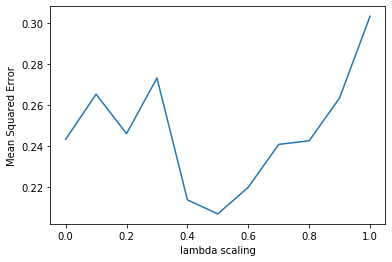

In [6]:
# fixed random seed so that I'm able to reproduce the results for every run.
random.seed(20200403)

# calculate MSQ per lambda
_, _, msq = q3_run(sarsa)

#plot msq on lambda scaling
plt.plot(np.arange(11) * 0.1,msq)
plt.ylabel("Mean Squared Error")
plt.xlabel("lambda scaling")
plt.show()

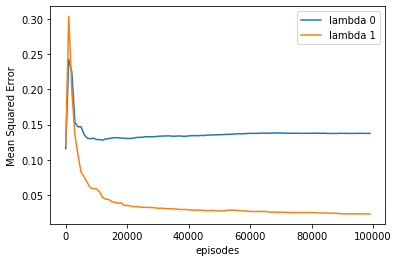

In [7]:
random.seed(20200403)

#calculate MSQ for lambda 0 & 1, over 100k episodes
_, _, msq = q3_run_100k(sarsa)

# plot msq on episodes
p0 = plt.plot(np.arange(100) * 1000,msq[0],label="lambda 0")
p1 = plt.plot(np.arange(100) * 1000,msq[1],label="lambda 1")
plt.ylabel("Mean Squared Error")
plt.xlabel("episodes")
plt.legend()
plt.show()

In [8]:
# sarsa_eligibility.py (Backward-view SARSA(lambda))

# scaling = lambda
def sarsa_eligibility(value,counter,scaling):
    # print "sarsa"
    state = State()
    state.dealercard = random.randint(1,10)
    state.playersum = random.randint(1,10)

    eligibility = np.zeros((2,11,22))

    while state != "terminal":
        # print "state is"
        # print state
        action = None
        e = 100.0 / (100.0 + np.sum(counter[:,state.dealercard, state.playersum],axis=0))
        if (random.random() < e):
            action = random.randint(0,1)
        else:
            action = np.argmax(value[:, state.dealercard, state.playersum])
        eligibility[action, state.dealercard, state.playersum] += 1
        old_dealercard = state.dealercard
        old_playersum = state.playersum
        counter[action, state.dealercard, state.playersum] += 1
        state, reward = step(state, action)
        # a hack to get around dividing by zero errors
        counter[counter == 0] = -1
        a = 1.0 / counter
        a[counter == -1] = 0
        counter[counter == -1] = 0

        g_scalar = reward
        if state == "terminal":
            g_scalar += 0
        else:
            g_scalar += np.amax(value[:,state.dealercard,state.playersum],axis=0)
        # print g_scalar
        g = g_scalar - value
        # print a*g*eligibility
        value = value + a*g*eligibility
        # a = 1.0 / counter[action,old_dealercard,old_playersum]
        # value[action,old_dealercard,old_playersum] = value[action,old_dealercard,old_playersum] + a*(g_scalar - value[action,old_dealercard,old_playersum])

        # decrease eligiblity traces by lambda scaling
        eligibility = eligibility * scaling


    return value, counter

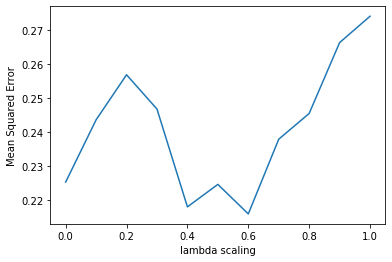

In [9]:
random.seed(20200403)

# calculate MSQ per lambda
_, _, msq = q3_run(sarsa_eligibility)

#plot msq on lambda scaling
plt.plot(np.arange(11) * 0.1,msq)
plt.ylabel("Mean Squared Error")
plt.xlabel("lambda scaling")
plt.show()

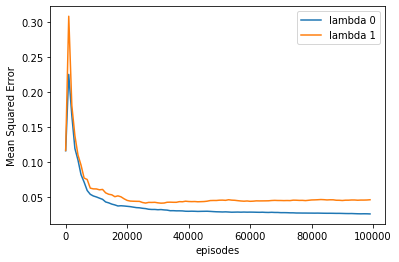

In [10]:
random.seed(20200403)

#calculate MSQ for lambda 0 & 1, over 100k episodes
_, _, msq = q3_run_100k(sarsa_eligibility)

# plot msq on episodes
p0 = plt.plot(np.arange(100) * 1000,msq[0],label="lambda 0")
p1 = plt.plot(np.arange(100) * 1000,msq[1],label="lambda 1")
plt.ylabel("Mean Squared Error")
plt.xlabel("episodes")
plt.legend()
plt.show()

In [11]:
# sarsa_approximation.py

def app_dealercard(dealercard):
    containers = []
    if dealercard in [1,2,3,4]:
        containers.append(0)
    if dealercard in [4,5,6,7]:
        containers.append(1)
    if dealercard in [7,8,9,10]:
        containers.append(2)
    return containers

def app_playersum(playersum):
    containers = []
    if playersum in [1,2,3,4,5,6]:
        containers.append(0)
    if playersum in [4,5,6,7,8,9]:
        containers.append(1)
    if playersum in [7,8,9,10,11,12]:
        containers.append(2)
    if playersum in [10,11,12,13,14,15]:
        containers.append(3)
    if playersum in [13,14,15,16,7,18]:
        containers.append(4)
    if playersum in [16,17,18,19,20,21]:
        containers.append(5)
    return containers

def getvalue(value,action,dealercard,playersum):
    total = 0
    for s1 in app_dealercard(dealercard):
        for s2 in app_playersum(playersum):
            total += value[action,s1,s2]
    return total;


# scaling = lambda
def sarsa_approx(value,scaling):
    # print "sarsa"
    state = State()
    state.dealercard = random.randint(1,10)
    state.playersum = random.randint(1,10)

    eligibility = np.zeros((2,3,6))

    while state != "terminal":
        # print "state is"
        # print state
        action = None
        e = 0.05
        if (random.random() < e):
            action = random.randint(0,1)
        else:
            action = 0 if getvalue(value,0,state.dealercard,state.playersum) > getvalue(value,1,state.dealercard,state.playersum) else 1

        for s1 in app_dealercard(state.dealercard):
            for s2 in app_playersum(state.playersum):
                eligibility[action, s1, s2] += 1
        old_dealercard = state.dealercard
        old_playersum = state.playersum
        state, reward = step(state, action)
        # a hack to get around dividing by zero errors
        a = 0.01

        g_scalar = reward
        if state == "terminal":
            g_scalar += 0
        else:
            g_scalar += max(getvalue(value,0,state.dealercard,state.playersum), getvalue(value,1,state.dealercard,state.playersum))
        # print g_scalar
        g = g_scalar - value
        # print a*g*eligibility
        value = value + a*g*eligibility
        # a = 1.0 / counter[action,old_dealercard,old_playersum]
        # value[action,old_dealercard,old_playersum] = value[action,old_dealercard,old_playersum] + a*(g_scalar - value[action,old_dealercard,old_playersum])

        # decrease eligiblity traces by lambda scaling
        eligibility = eligibility * scaling


    return value

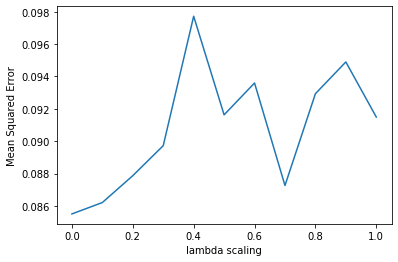

In [12]:
random.seed(20200403)

msq = np.zeros(11)
for k in range(11):
    td_value = np.zeros((2,3,6))
    for i in range(1000):
        td_value = sarsa_approx(td_value,0.1*k)

    builtvalue = np.zeros((2,11,22))
    for x in range(2):
        for y in range(10):
            for z in range(21):
                builtvalue[x,(y+1),(z+1)] = getvalue(td_value,x,(y+1),(z+1))
    msq[k] = np.sum(np.square(value - builtvalue)) / (2.0*11*22)

plt.plot(np.arange(11) * 0.1,msq)
plt.ylabel("Mean Squared Error")
plt.xlabel("lambda scaling")
plt.show()

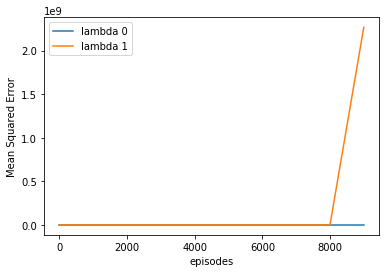

In [13]:
random.seed(20200403)

msq = np.zeros((2,10))
for k in range(2):
    td_value = np.zeros((2,3,6))
    for i in range(10000):
        td_value = sarsa_approx(td_value,k)
        if i % 1000 == 0:
            builtvalue = np.zeros((2,11,22))
            for x in range(2):
                for y in range(10):
                    for z in range(21):
                        builtvalue[x,(y+1),(z+1)] = getvalue(td_value,x,(y+1),(z+1))
            msq[k,int(i / 1000)] = np.sum(np.square(value - builtvalue)) / (2.0*11*22)

plt.plot(np.arange(10) * 1000,msq[0],label="lambda 0")
plt.plot(np.arange(10) * 1000,msq[1],label="lambda 1")
plt.ylabel("Mean Squared Error")
plt.xlabel("episodes")

plt.legend(loc='upper left')
plt.show()